# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
impt_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
impt_data

,0,1,2,3,4,5,6
0,3,1,8,2,6,4,14
1,2,2,7,7,6,2,14
2,3,1,3,3,7,7,14
3,4,1,8,2,1,1,4
4,3,1,1,5,5,3,13
...,...,...,...,...,...,...,...
22439,4,1,7,5,3,4,13
22440,4,1,7,2,3,8,14
22441,3,2,5,6,4,8,12
22442,3,1,4,6,5,6,-1


In [4]:
labels_pd = impt_data.pop("6")
labels_test_pd = test_data

In [5]:
# include_columns = ["CO_GT", "PT08_S1_CO", "PT08_S2_NMHC"]
data_pd = impt_data#[include_columns]
data_test_pd = test_data#[include_columns]

In [6]:
data = data_pd.to_numpy()
labels = labels_pd.to_numpy()
X_test = data_test_pd.to_numpy()
# Y_test = labels_test_pd.to_numpy()
print(data.shape)
print(X_test.shape)

(22444, 6)
(5611, 6)


# Train Test Split

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0, test_size = 0.3)

In [8]:
enc = OneHotEncoder(categories='auto')
le = LabelEncoder()
Y_pos_train = le.fit_transform(np.expand_dims(Y_train, 1))
Y_pos_val = le.fit_transform(np.expand_dims(Y_val, 1))
Y_OH_train = enc.fit_transform(np.expand_dims(Y_pos_train, 1)).toarray()
Y_OH_val = enc.transform(np.expand_dims(Y_pos_val, 1)).toarray()

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
X_train, Y_OH_train, X_val, Y_OH_val, X_test = map(torch.tensor, (X_train, Y_OH_train, X_val, Y_OH_val, X_test))

In [10]:
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()

In [19]:
Y_OH_train.shape

torch.Size([15710, 18])

# Cuda Support

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test  = X_test.to(device)
Y_OH_train = Y_OH_train.to(device)
Y_OH_val = Y_OH_val.to(device)

# FF Network

In [20]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(6, 55),
#             nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.Linear(55,40),
#             nn.BatchNorm1d(40),
            nn.ReLU(), 
            nn.Linear(40, 18),
        )
           
    def forward(self, X):
        return(self.net(X))

In [21]:
ff_n = FF_Network()
ff_n = ff_n.to(device)
loss_fn = nn.CrossEntropyLoss()

RuntimeError: CUDA error: device-side assert triggered

In [15]:
def accuracy(Y_hat, Y):
    accuracy = accuracy_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    f1_scr = f1_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1), average='macro')
    kappa = cohen_kappa_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    return(accuracy, f1_scr, kappa)

In [16]:
def train(X, Y, model, loss_fn = loss_fn, lr = 0.02, epochs = 2500, batch_size = 512):
    loss_b = []
    acc_b = []
    acc = 0
    optm = optim.Adam(ff_n.parameters(), lr = lr)
    Y_temp = Y.to('cpu')
    Y = np.argmax(Y_temp, 1)
    Y = Y.to(device)
    for i in tqdm_notebook(range(epochs)):
        for i in range(X.shape[0] // batch_size):
            local_X, local_Y, local_y_temp = X[i*batch_size:(i+1)*batch_size,], Y[i*batch_size:(i+1)*batch_size,], Y_temp[i*batch_size:(i+1)*batch_size,]
            Y_hat = model.forward(local_X)
            loss = loss_fn(Y_hat, local_Y)
            acc, _, _ = accuracy(Y_hat, local_y_temp)
            loss_b.append(loss.item())
            acc_b.append(acc)
            loss.backward()
            optm.step()
            optm.zero_grad()
    return(loss_b, acc_b, acc)

In [17]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_OH_train, ff_n, loss_fn, lr = 0.002, epochs = 600, batch_size = 4096)

RuntimeError: CUDA error: device-side assert triggered

NameError: name 'loss_b' is not defined

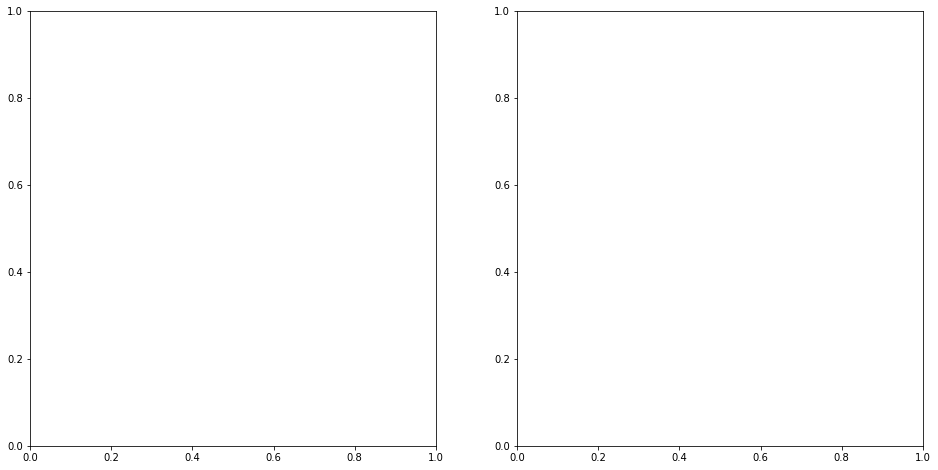

In [18]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('time progress')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('time_progress')
ax2.set_ylabel('acc')

In [ ]:
# ff_n.eval()
print("Train set accuracy, f1 score: ", accuracy(ff_n.forward(X_train), Y_OH_train), "\nValidation set accuracy, f1 score: ", accuracy(ff_n.forward(X_val), Y_OH_val))#, "\nTest set accuracy, f1 score: ", accuracy(ff_n.forward(X_test), Y_OH_test))

# Visual Evaluation

In [ ]:
cm = confusion_matrix(np.argmax(Y_OH_val.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_val).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

In [ ]:
cm = confusion_matrix(np.argmax(Y_OH_train.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_train).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

# Saving Model

In [ ]:
torch.save(ff_n.state_dict(), './weights')

In [ ]:
model = FF_Network()
model.load_state_dict(torch.load('./weights'))
model.eval()
model.to(device)

In [ ]:
Y_test_pred = model.forward(X_test)

In [ ]:
print("Train set Accuracy, F1 score, Cohen's Kappa: ", accuracy(model.forward(X_train), Y_OH_train), "\nValidation set Accuracy, F1 score, Cohens Kappa: ", accuracy(model.forward(X_val), Y_OH_val))

In [ ]:
import csv

with open('submission.csv', 'w', newline='') as file:
    with open('test.csv', 'r') as inp:
        writer = csv.writer(file)
        reader = csv.reader(inp)
        heading = next(reader)
        heading.append("class")
        writer.writerow(['class'])
        for i, row in enumerate(reader):
            writer.writerow([np.argmax(Y_test_pred.to('cpu').detach().numpy(), 1)[i]])